# Unsupervised Learning Using K-Means Clustering on California Housing Data

In this assignment, we will work with the California Housing dataset to explore unsupervised learning techniques using K-Means clustering. The task is to apply K-Means clustering, evaluate the results, and perform a comparative analysis with different cluster configurations. We will also analyze how the clustering results can be used to segment housing data for further insights.

In this notebook, we will:

1. Apply K-Means Clustering on the California Housing Dataset based on longitude, latitude and median_income
2. Optimize the Number of Clusters Using Silhouette Score: Calculate the silhouette score for different cluster configurations to evaluate the quality of clustering.
3. Analyze the Clustering Results
4. Visualize the clusters using scatter plots and compare the results for different values of k.
5. Discuss the distribution of data points in each cluster and their corresponding housing features (e.g., median income).
6. Interpret the results and explain how the clusters represent different segments of the housing market.
7. Comparison with Other Clustering Algorithms (Optional)
8. Optionally, compare K-Means with another clustering algorithm, such as DBSCAN, and discuss which performs better.

# Download the Data

In [126]:
# Download the data 
import os
import tarfile
import urllib.request
import warnings  # Import the warnings module

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


# Definition of how to fetch the data
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)

    # Suppress the DeprecationWarning for tarfile extraction
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=DeprecationWarning)
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path, filter=None)
        housing_tgz.close()

In [127]:
import matplotlib.pyplot as plt

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "plots")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [128]:
# Execute fetching
fetch_housing_data()

In [129]:
import pandas as pd

# Definition of how to Load the housing csv from the path
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [130]:
import numpy as np

# to make this notebook's output identical at every run
np.random.seed(42)

In [131]:
# Create the housing data frame
housing = load_housing_data()

# K-Means Clustering algorithm steps

### 1. Select relevant features

In [132]:
housing_data_selected = housing[["longitude", "latitude", "median_income"]]

### 2. Creating a Pipeline with k and applying a StandardScaler

In [133]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

k_values = range(2, 30)

silhouette_scores = []

for k in k_values:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=k, random_state=42))
    ])
    
    pipeline.fit(housing_data_selected)
    
    cluster_labels = pipeline.predict(housing_data_selected)
    
    score = silhouette_score(housing_data_selected, cluster_labels)
    silhouette_scores.append(score)


### 3. Analyze the Silhouette scores for different k values

Saving figure Silhouette_Scores_for_Different_k_Values


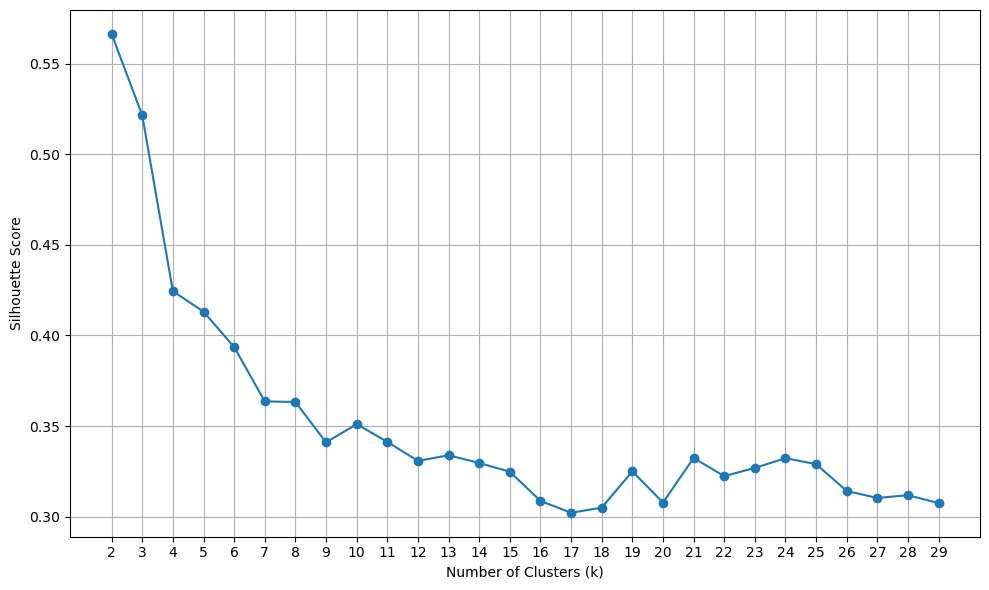

In [134]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
# plt.title('Silhouette Scores for Different k Values')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
save_fig("Silhouette_Scores_for_Different_k_Values")
plt.show()

### 4. Analyze the Silhouette coefficient for different k values

Saving figure silhouette_analysis_plot


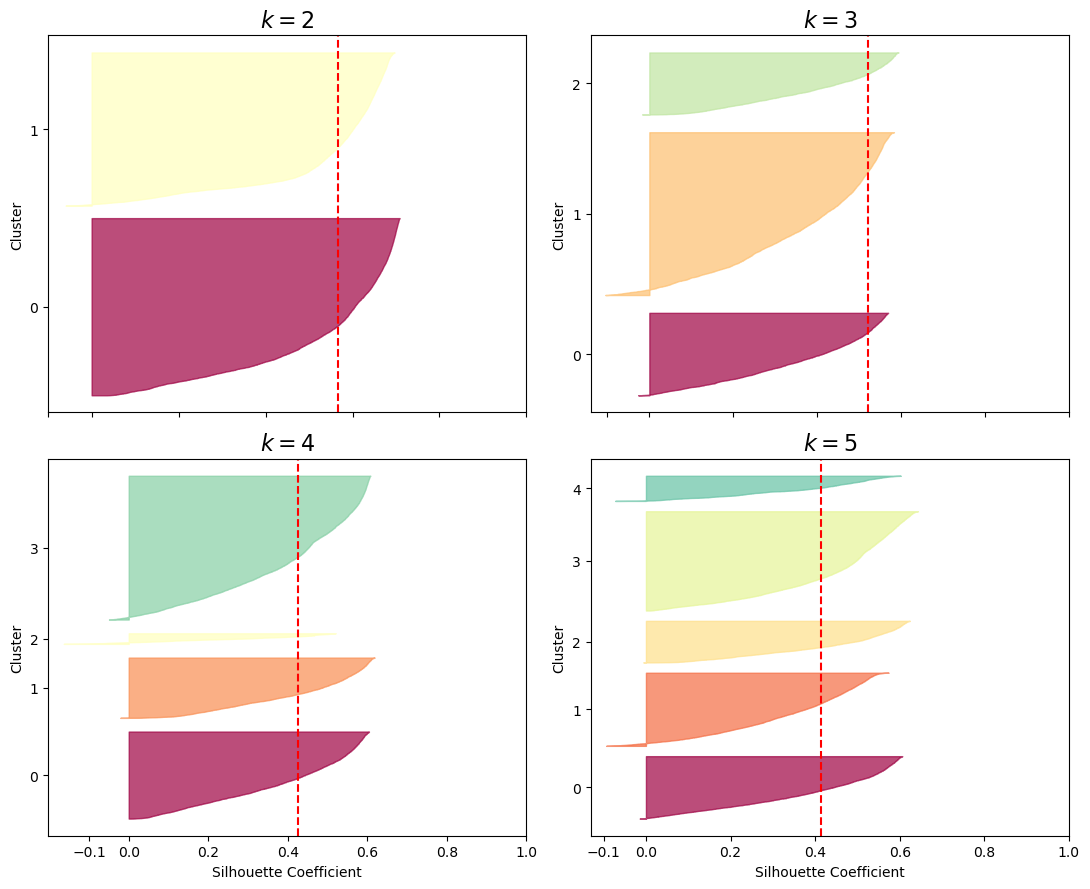

In [135]:
import matplotlib as mpl
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

# Running KMeans clustering for k values from 2 to 6
k_values = [KMeans(n_clusters=k, random_state=42).fit(housing_data_selected) for k in range(2, 7)]

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = k_values[k - 1].labels_
    silhouette_coefficients = silhouette_samples(housing_data_selected, y_pred)

    padding = len(housing_data_selected) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (2, 3, 4, 5):
        plt.ylabel("Cluster")
    
    if k in (2, 3, 4, 5):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    if k in (4, 5):
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

### 5. Choose the optimal k value

In [143]:
# Define the optimal number of clusters
optimal_k = 2

# Create a pipeline with scaling and KMeans
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=optimal_k, random_state=42))
])

# Fit the pipeline to the data
final_pipeline.fit(housing_data_selected)

# Predict cluster labels
housing['cluster'] = final_pipeline.predict(housing_data_selected)

### 6. Visualize the cluster using scatter plots

Saving figure K-Means_Clustering_on_California_Housing_Dataset


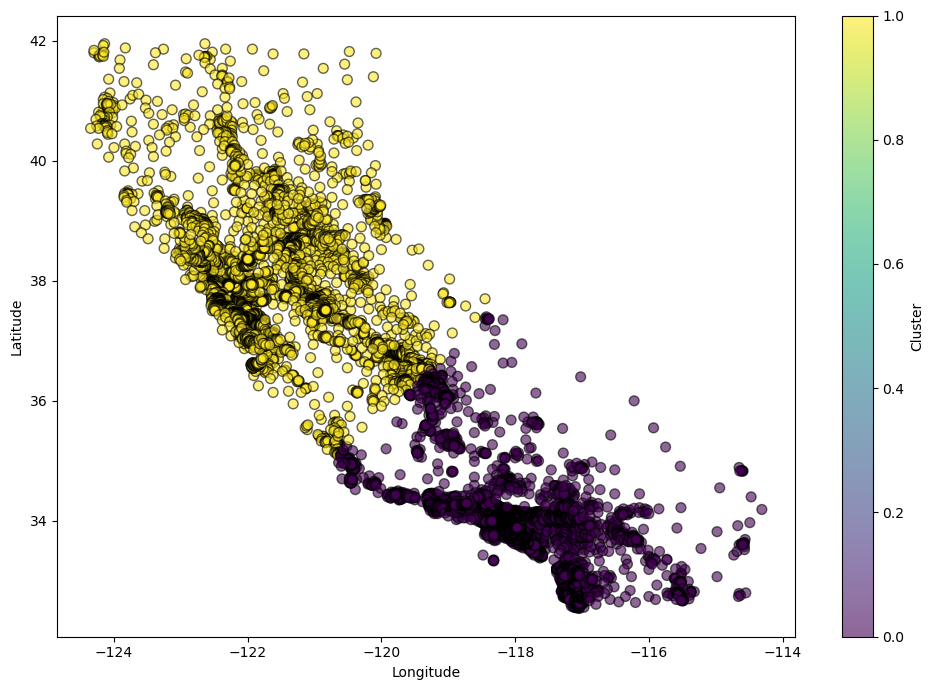

In [144]:
import matplotlib.pyplot as plt

# Scatter plot of clusters with longitude and latitude
plt.figure(figsize=(10, 7))
plt.scatter(housing['longitude'], housing['latitude'], c=housing['cluster'], cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)
# plt.title(f"K-Means Clustering with k=4 on California Housing Dataset")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label='Cluster')
save_fig("K-Means_Clustering_on_California_Housing_Dataset")
plt.show()

# DBSCAN Clustering algorithm steps

### 1. Creating a pipeline with eps/ min_samples and applying a StandardScaler

In [150]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define a range of epsilon (eps) values to explore
eps_values = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Define a range of min_samples values to explore
min_samples_values = [1, 2, 3, 5, 7]

# List to store silhouette scores for each combination of eps and min_samples
silhouette_scores = []

# Iterate over both eps and min_samples values
for eps in eps_values:
    for min_samples in min_samples_values:
        # Create a pipeline with scaling and DBSCAN
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('dbscan', DBSCAN(eps=eps, min_samples=min_samples))
        ])
        
        # Fit the pipeline to the data
        pipeline.fit(housing_data_selected)
        
        # Predict cluster labels (-1 labels indicate noise points)
        cluster_labels = pipeline['dbscan'].labels_
        
        # Only calculate silhouette score if there are more than one cluster (ignoring noise points)
        if len(set(cluster_labels)) > 1 and -1 in cluster_labels:
            # Calculate silhouette score
            score = silhouette_score(housing_data_selected, cluster_labels)
            silhouette_scores.append((eps, min_samples, score))
        else:
            silhouette_scores.append((eps, min_samples, None))  # Append None if clustering didn't result in valid clusters


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define a range of epsilon (eps) values to explore
eps_values = [0.1,0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Define a range of min_samples values to explore
min_samples_values = [1, 2, 3, 5, 7, 10, 20, 30]

# List to store silhouette scores for each combination of eps and min_samples
silhouette_scores = []

# Iterate over both eps and min_samples values
for eps in eps_values:
    for min_samples in min_samples_values:
        # Create a pipeline with scaling and DBSCAN
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('dbscan', DBSCAN(eps=eps, min_samples=min_samples))
        ])
        
        # Fit the pipeline to the data
        pipeline.fit(housing_data_selected)
        
        # Predict cluster labels (-1 labels indicate noise points)
        cluster_labels = pipeline['dbscan'].labels_
        
        # Only calculate silhouette score if there are more than one cluster (ignoring noise points)
        if len(set(cluster_labels)) > 1 and -1 in cluster_labels:
            # Calculate silhouette score
            score = silhouette_score(housing_data_selected, cluster_labels)
            silhouette_scores.append((eps, min_samples, score))
        else:
            silhouette_scores.append((eps, min_samples, None))  # Append None if clustering didn't result in valid clusters


### 2. Analyze the Silhouette scores for different eps and min_samples values

In [151]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Correct unpacking of eps, min_samples, and scores
data = pd.DataFrame({
    'eps': [eps for eps, min_samples, score in silhouette_scores if score is not None],
    'min_samples': [min_samples for eps, min_samples, score in silhouette_scores if score is not None],
    'silhouette_score': [score for eps, min_samples, score in silhouette_scores if score is not None]
})

# Correct the use of pivot table to pass the correct keyword arguments
heatmap_data = data.pivot(index='min_samples', columns='eps', values='silhouette_score')

### 3. Plot the heatmap for DBSCAN

Saving figure Silhouette_Score_Heatmap_for_DBSCAN


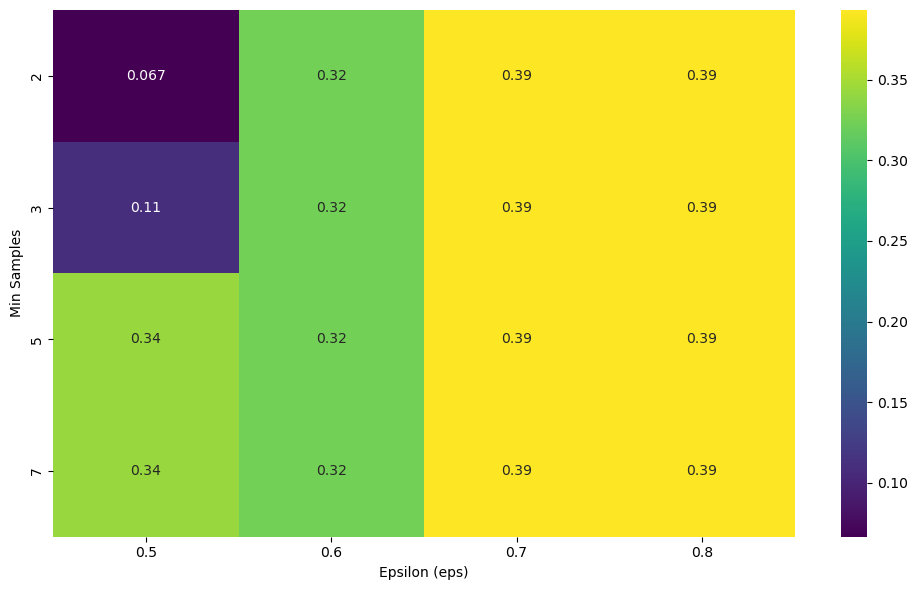

In [154]:
# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='viridis', annot=True)
# plt.title('Silhouette Score Heatmap for DBSCAN')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Min Samples')
save_fig("Silhouette_Score_Heatmap_for_DBSCAN")
plt.show()

### 4. Visualize the cluster using scatter plots

Saving figure DBSCAN _Clustering_on_California_Housing_Dataset


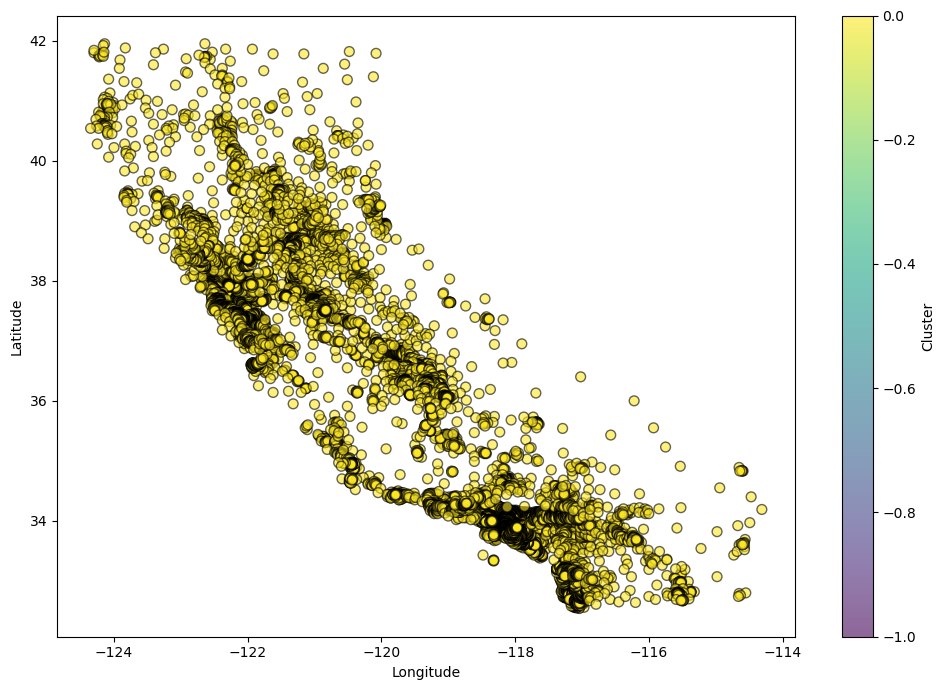

In [146]:
from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define the parameters for DBSCAN
eps_value = 0.4  # You can adjust the eps value based on your data
min_samples_value = 5  # Minimum samples required to form a cluster

# Create a pipeline with scaling and DBSCAN
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dbscan', DBSCAN(eps=eps_value, min_samples=min_samples_value))
])

# Fit the pipeline to the data
final_pipeline.fit(housing_data_selected)

# Predict cluster labels
housing['cluster'] = final_pipeline['dbscan'].labels_

# Visualize the clusters
plt.figure(figsize=(10, 7))
plt.scatter(
    housing['longitude'], 
    housing['latitude'], 
    c=housing['cluster'], 
    cmap='viridis', 
    marker='o', 
    edgecolor='k', 
    s=50,
    alpha=0.6
)
# plt.title(f"DBSCAN Clustering with eps={eps_value} on California Housing Dataset")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label='Cluster')
save_fig("DBSCAN _Clustering_on_California_Housing_Dataset")
plt.show()